# Step 04
# Evaluation of performance

In [34]:
%matplotlib inline

In [35]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import skimage.io
import skimage.morphology
import skimage.segmentation

import utils.evaluation

# Configuration

In [36]:
from config import config_vars

# Partition of the data to make predictions (test or validation)
partition = "validation"

experiment_name = 'neutros_v3'

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)



config_vars['min_nucleus_size'] = 5

config_vars

{'augment_images': True,
 'batch_size': 10,
 'boundary_boost_factor': 1,
 'boundary_labels_dir': '/storage/data/2018_tim_tracking/unet/boundary_labels/',
 'boundary_size': 2,
 'cell_min_size': 40,
 'create_split_files': True,
 'crop_size': 256,
 'csv_log_file': '/storage/data/2018_tim_tracking/unet/experiments/neutros_v3/log.csv',
 'elastic_augmentations': 10,
 'elastic_distortion': 5,
 'elastic_points': 16,
 'epochs': 15,
 'experiment_dir': '/storage/data/2018_tim_tracking/unet/experiments/neutros_v3/out/',
 'labels_out_dir': '/storage/data/2018_tim_tracking/unet/experiments/neutros_v3/out/segm/',
 'learning_rate': 1e-05,
 'max_training_images': 0,
 'min_nucleus_size': 5,
 'model_file': '/storage/data/2018_tim_tracking/unet/experiments/neutros_v3/model.hdf5',
 'normalized_images_dir': '/storage/data/2018_tim_tracking/unet/norm_images/',
 'object_dilation': 3,
 'path_files_test': '/storage/data/2018_tim_tracking/unet/test.txt',
 'path_files_training': '/storage/data/2018_tim_tracking/u

In [37]:
# To evaluate segmentations produced by other segmentation algorithms (e.g. CellProfiler), 
# manually modify the following config var:

#config_vars["labels_out_dir"] = "/data/cellprofiler_segmentations/"
#config_vars["object_dilation"] = 2

# Auxiliary visualization function

In [38]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

# Run the evaluation
Predictions are stored in Step 03 and loaded here for evaluation

In [39]:

all_images = data_partitions[partition]
print(all_images)

['series_0009_annotation.png', 'series_0003_annotation.png', 'series_0012_annotation.png']


series_0009_annotation.png
/storage/data/2018_tim_tracking/unet/experiments/neutros_v3/out/segm/series_0009_annotation.png
series_0003_annotation.png
/storage/data/2018_tim_tracking/unet/experiments/neutros_v3/out/segm/series_0003_annotation.png
series_0012_annotation.png
/storage/data/2018_tim_tracking/unet/experiments/neutros_v3/out/segm/series_0012_annotation.png


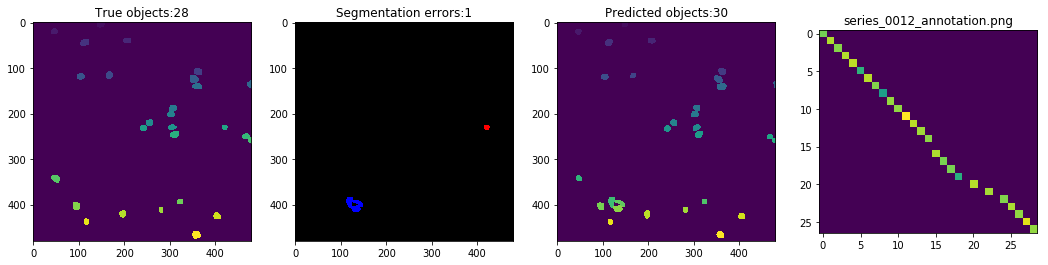

In [41]:
results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])



for image_name in all_images:
    # Load ground truth data
    print(image_name)
    img_filename = os.path.join(config_vars["raw_annotations_dir"], os.path.splitext(image_name)[0]+'.png')
    ground_truth = skimage.io.imread(img_filename)
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth[:,:,0]
    
    # Transform to label matrix
    ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    print(pred_filename)
    prediction = skimage.io.imread(pred_filename)
    
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    if image_name == all_images[2]:
        show(ground_truth, prediction, image_name=image_name)

# Report of results

'series_0009_annotation.png'

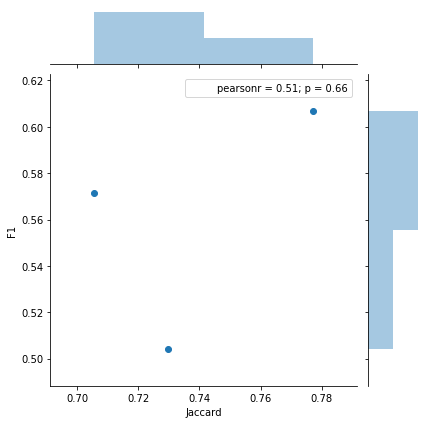

In [42]:
# Display accuracy results

average_performance = results.groupby("Threshold").mean().reset_index()

R = results.groupby("Image").mean().reset_index()
g = sb.jointplot(data=R[R["F1"] > 0.1], x="Jaccard", y="F1")

average_performance
R.sort_values(by="F1",ascending=False).loc[1, "Image"]

,Threshold,F1,Jaccard
0,0.50,0.848374,0.737487
1,0.55,0.836470,0.737487
2,0.60,0.824565,0.737487
3,0.65,0.812660,0.737487
4,0.70,0.789672,0.737487
5,0.75,0.651790,0.737487
6,0.80,0.486765,0.737487
7,0.85,0.257323,0.737487
8,0.90,0.073465,0.737487
9,0.95,0.026667,0.737487


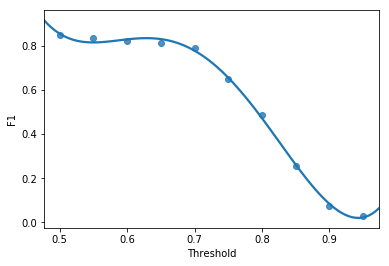

In [43]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=4, ci=None)
average_performance

In [44]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.5607750410338059
Jaccard index: 0.7374871165385777


In [45]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,250,625,900,10000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      10.0
Small nuclei      2.0
Normal nuclei     NaN
Large nuclei      NaN
Name: False_Negative, dtype: float64

In [20]:
# Summarize splits and merges

print("Splits:",np.sum(splits_merges["Splits"]))
print("Merges:",np.sum(splits_merges["Merges"]))

Splits: 228
Merges: 89


In [21]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 55757
